In [2]:
import os
import csv
import math
import itertools

import pandas as pd
pd.set_option('display.max_columns', None)
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import preprocessing
from scipy import sparse
import networkx as nx

from mbi import (
    Dataset,
    FactoredInference,
    Domain,
    LocalInference,
    MixtureInference,
    PublicInference,
)

In [3]:
data = Dataset.load("data/diabetes_processed.csv", "data/diabetes_processed.json")

In [4]:
N = data.df.shape[0]
df = pd.DataFrame(columns=['col1','col2', 'score'])
idx = 0

In [5]:
# source: https://github.com/usnistgov/PrivacyEngCollabSpace/blob/master/tools/de-identification/Differential-Privacy-Synthetic-Data-Challenge-Algorithms/rmckenna/select-queries.ipynb

# calculate mutual info between every pair of attributes

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    # print(a,b,score)
    df.loc[idx] = [a,b,score]
    df.loc[idx+1] = [b,a,score]
    idx += 2

df = df.sort_values('score')


/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1968762910.py:11: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])


In [6]:
df.head()

,col1,col2,score
40,BloodPressure,Outcome,0.041110
41,Outcome,BloodPressure,0.041110
15,Outcome,Pregnancies,0.042854
14,Pregnancies,Outcome,0.042854
51,Outcome,SkinThickness,0.056580


In [7]:
nodes = data.domain.attrs
weights = df[df.col1.isin(nodes) & df.col2.isin(nodes)]
weights.head()

,col1,col2,score
40,BloodPressure,Outcome,0.041110
41,Outcome,BloodPressure,0.041110
15,Outcome,Pregnancies,0.042854
14,Pregnancies,Outcome,0.042854
51,Outcome,SkinThickness,0.056580


In [8]:
G = nx.Graph()
G.add_nodes_from(nodes)

for e1, e2, w in zip(weights['col1'], weights['col2'], weights['score']):
    G.add_edge(e1, e2, weight=w)

mst = nx.maximum_spanning_tree(G)

es = list(mst.edges)
print(es)
print(len(es))

[('Pregnancies', 'DiabetesPedigreeFunction'), ('Glucose', 'DiabetesPedigreeFunction'), ('BloodPressure', 'DiabetesPedigreeFunction'), ('SkinThickness', 'DiabetesPedigreeFunction'), ('Insulin', 'DiabetesPedigreeFunction'), ('BMI', 'DiabetesPedigreeFunction'), ('DiabetesPedigreeFunction', 'Age'), ('DiabetesPedigreeFunction', 'Outcome')]
8


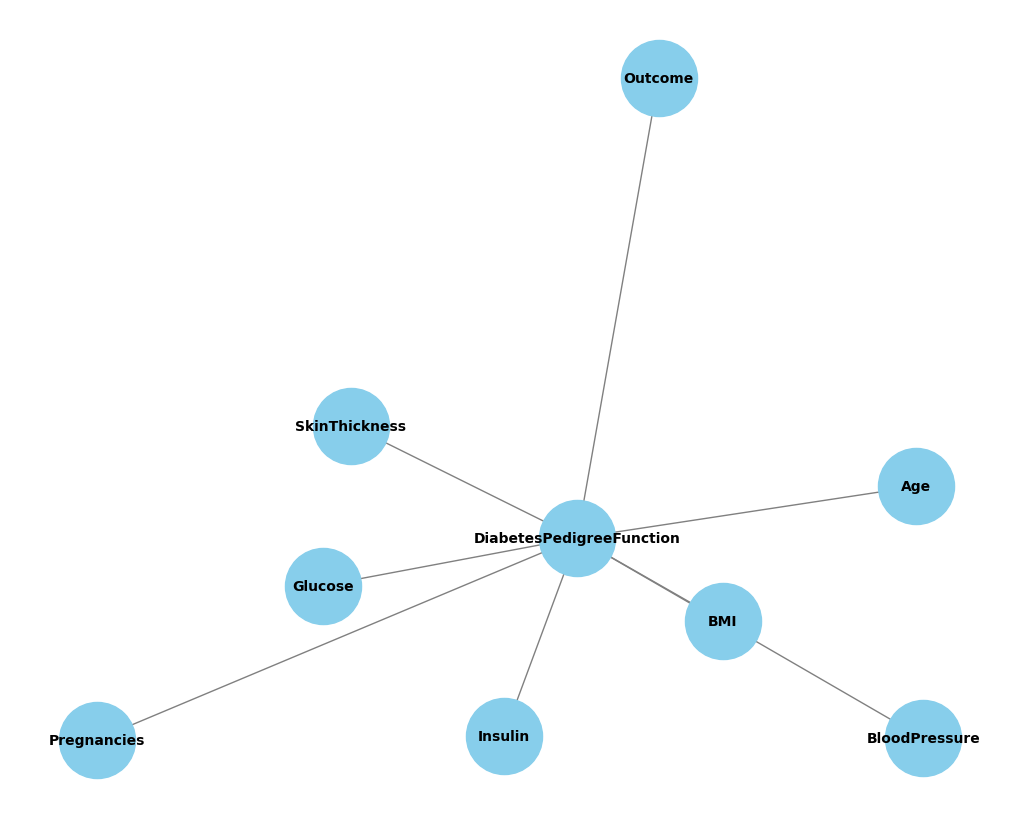

In [9]:
plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(mst, pos, with_labels=True, node_color='skyblue', node_size=3000, font_size=10, font_weight='bold', edge_color='gray')

# Show the plot
plt.show()

In [10]:
df = pd.DataFrame(columns=['col1','col2', 'score', 'bound'])
idx = 0

entropies = {key: -1 for key in data.domain.attrs}

for attr in data.domain.attrs:
    # Calculate probabilities
    probabilities = data.df[attr].value_counts(normalize=True)
    # Calculate Shannon entropy
    entropy = -np.sum(probabilities * np.log2(probabilities))

    entropies[attr] = entropy

for a,b in itertools.combinations(data.domain.attrs, 2):
    A = data.project(a).datavector() / N
    B = data.project(b).datavector() / N
    AB = data.project([a,b]).datavector() / N
    nz = AB > 0

    score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
    df.loc[idx] = [a,b,score,min(entropies[a],entropies[b])]
    idx += 1

df = df.sort_values('score')

# cannot use 0.1 needs 73.9 PiB
#            0.25 needs 4577.54 GB
#            0.4 needs 25.89 GB

df = df[df['score'] > df['bound'] * 0.5]
df

/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1463367858.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1463367858.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1463367858.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1463367858.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])
/var/folders/v6/_91hyscx6rq9cg3d_0sg4vy40000gn/T/ipykernel_38368/1463367858.py:20: RuntimeWarning: divide by zero encountered in log
  score = np.dot(AB[nz], np.log(AB / np.outer(A,B).flatten())[nz])


,col1,col2,score,bound
5,Pregnancies,DiabetesPedigreeFunction,1.953094,3.482048
23,SkinThickness,DiabetesPedigreeFunction,2.674039,4.469723
18,BloodPressure,DiabetesPedigreeFunction,2.813796,4.792470
27,Insulin,DiabetesPedigreeFunction,2.881958,4.639937
33,DiabetesPedigreeFunction,Age,2.984857,5.028842
12,Glucose,DiabetesPedigreeFunction,4.158725,6.751021
30,BMI,DiabetesPedigreeFunction,4.733394,7.580093


In [11]:
tuple_list = list(zip(df['col1'], df['col2']))
es.extend(tuple_list)
es = list(set(es))
print(es)
print(len(es))

[('DiabetesPedigreeFunction', 'Outcome'), ('Insulin', 'DiabetesPedigreeFunction'), ('BMI', 'DiabetesPedigreeFunction'), ('Pregnancies', 'DiabetesPedigreeFunction'), ('DiabetesPedigreeFunction', 'Age'), ('Glucose', 'DiabetesPedigreeFunction'), ('SkinThickness', 'DiabetesPedigreeFunction'), ('BloodPressure', 'DiabetesPedigreeFunction')]
8


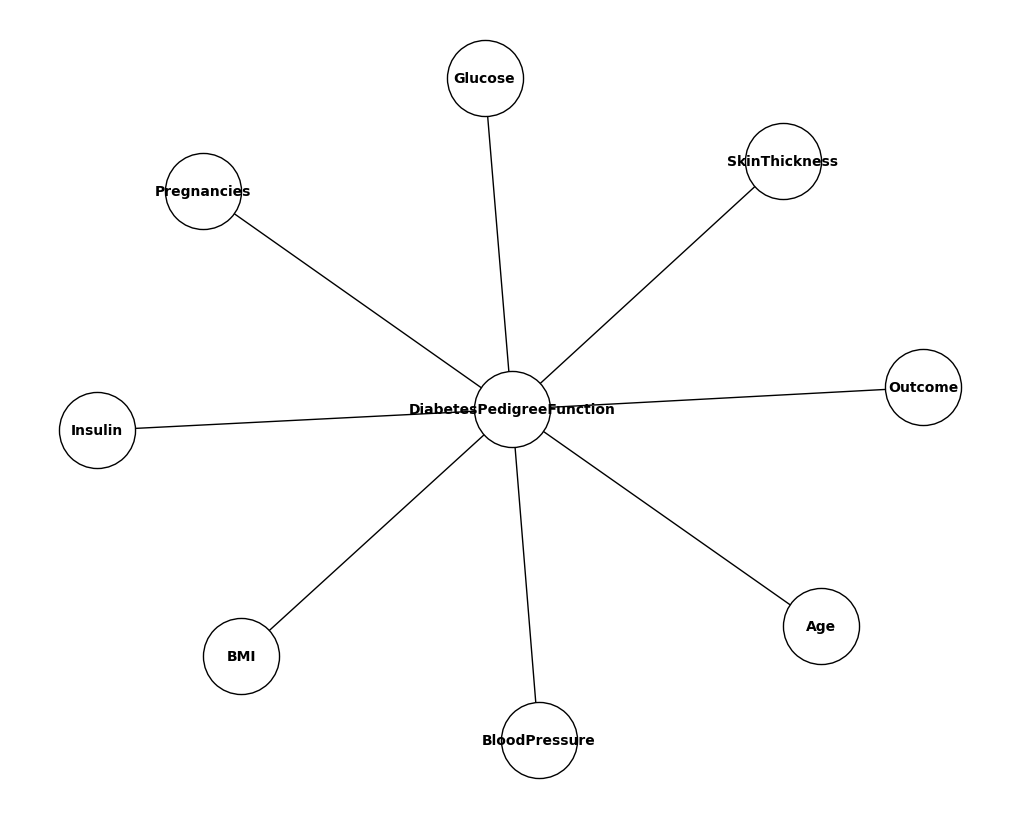

In [12]:
# Create a directed graph
G = nx.Graph()

# Add edges to the graph
G.add_edges_from(es)

plt.figure(figsize=(10, 8))  # Set the figure size
pos = nx.spring_layout(G)  # Use spring layout for positioning nodes
nx.draw(G, pos, with_labels=True, node_color='white', node_size=3000, font_size=10, font_weight='bold', edge_color='black', node_shape='o', edgecolors='black')

# Save the figure as a PDF
plt.savefig("paper/images/diabetes_mst.pdf", format="pdf", bbox_inches='tight')  # Specify the format as PDF

# Show the plot
plt.show()

In [13]:
cliques = list(nx.find_cliques(G))
for c in cliques:
    print(c)

['DiabetesPedigreeFunction', 'Pregnancies']
['DiabetesPedigreeFunction', 'Glucose']
['DiabetesPedigreeFunction', 'Age']
['DiabetesPedigreeFunction', 'BloodPressure']
['DiabetesPedigreeFunction', 'BMI']
['DiabetesPedigreeFunction', 'Outcome']
['DiabetesPedigreeFunction', 'Insulin']
['DiabetesPedigreeFunction', 'SkinThickness']
